In [1]:
import os
import pandas as pd

In [2]:
df = pd.read_csv("Secom.csv")

In [3]:
# 특징과 라벨 분리
X = df.drop('Y', axis = 1)
Y = df['Y']

In [4]:
# 학습 데이터와 평가 데이터 분할
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [5]:
# 특징이 매우 많음을 확인
Train_X.shape

(1175, 590)

In [6]:
# 클래스 불균형 확인
Train_Y.value_counts()

-1    1092
 1      83
Name: Y, dtype: int64

In [7]:
# 클래스 불균형 비율 계산
Train_Y.value_counts().iloc[0] / Train_Y.value_counts().iloc[-1]

13.156626506024097

In [8]:
# kNN을 사용한 클래스 불균형 테스트
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
kNN_model = KNN(n_neighbors = 11).fit(Train_X, Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

# 재현율이 0%로 불균형이 심각한 수준이라 보임

0.0
0.9464285714285714


In [9]:
# 비용 민감 모델 적용전 Logistic Regression 모델 테스트
from sklearn.linear_model import LogisticRegression as LR
model = LR(max_iter = 100000).fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))
# knn과 비교해서는 재현율이 좋지만 여전히 불균형하다

0.23809523809523808
0.9056122448979592


c:\users\jaehwan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# cut off value를 조정, 0.3일때
# Test_X의 확률값 저장
probs = model.predict_proba(Test_X)
probs = pd.DataFrame(probs, columns = model.classes_)

cut_off_value = 0.3

pred_Y = 2 * (probs.iloc[:, -1] >= cut_off_value) - 1
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))
# cut off value를 적용했지만 여전히 불균형
# cut off value 를 적당한 값으로 설정하지 못했기 때문이다.

0.3333333333333333
0.8903061224489796


In [11]:
# cut off value를 조정하는 함수 
def cost_sensitive_model(model, cut_off_value, Test_X, Test_Y):
    probs = model.predict_proba(Test_X)
    probs = pd.DataFrame(probs, columns = model.classes_)
    pred_Y = 2 * (probs.iloc[:, -1] >= cut_off_value) - 1
    recall = recall_score(Test_Y, pred_Y)
    accuracy = accuracy_score(Test_Y, pred_Y)
    return recall, accuracy

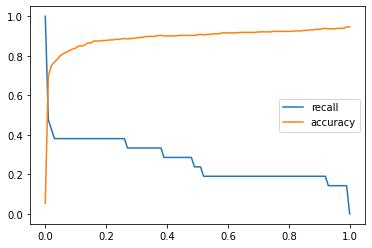

In [12]:
# cut off value에 따른 recall과 accuracy 변화 확인
# 0.01 부터 1까지 cut off value 적용 결과 그래프 출력
from matplotlib import pyplot as plt
import numpy as np

cut_off_value_list = np.linspace(0, 1, 101)
recall_list = []
accuracy_list = []

for c in cut_off_value_list:
    recall, accuracy = cost_sensitive_model(model, c, Test_X, Test_Y)
    recall_list.append(recall)
    accuracy_list.append(accuracy)

%matplotlib inline    
plt.plot(cut_off_value_list, recall_list, label = 'recall')   
plt.plot(cut_off_value_list, accuracy_list, label = 'accuracy')    
plt.legend()